# CineMatch – Personalized Movie Recommendation System

In [1]:
# Import the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## 1. Data Acquisition and Loading

In [2]:
# Load dataset  and create a dataframes
movies = pd.read_csv("../data/movies.csv")
ratings = pd.read_csv("../data/ratings.csv")
tags = pd.read_csv("../data/tags.csv")
 

movies["genres"] = movies["genres"].replace("(no genres listed)", "Other").fillna("")


In [3]:
print("First five rows of the Movies dataset:")
movies.head(5)

First five rows of the Movies dataset:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print("First five rows of the Ratings dataset:")
ratings.head(5)

First five rows of the Ratings dataset:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
print("First five rows of the Tags dataset:")
tags.head(5)

First five rows of the Tags dataset:


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## 2. EDA with Visualizations

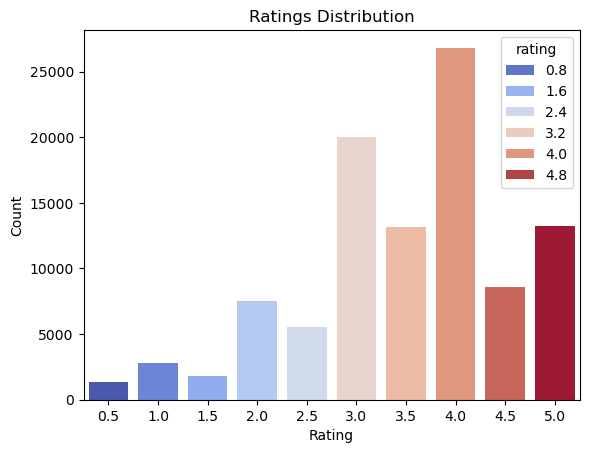

In [6]:
# Ratings distribution
sns.countplot(x="rating", data=ratings, hue="rating",palette="coolwarm")
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

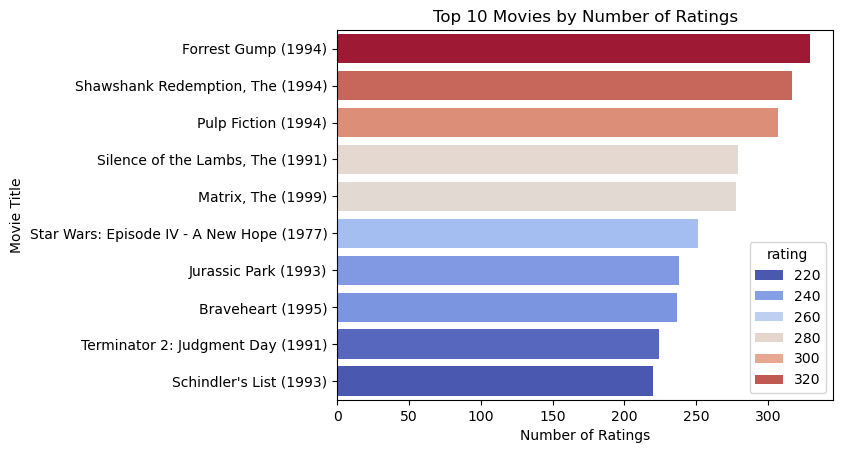

In [7]:
# Top 10 Movies by Number of Ratings
top_movies = (
    ratings.groupby("movieId")["rating"]
    .count()
    .reset_index()
    .merge(movies, on="movieId")
    .sort_values("rating", ascending=False)
    .head(10)
)

sns.barplot( x="rating", y="title",hue='rating', data=top_movies, palette="coolwarm")
plt.title("Top 10 Movies by Number of Ratings")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.show()

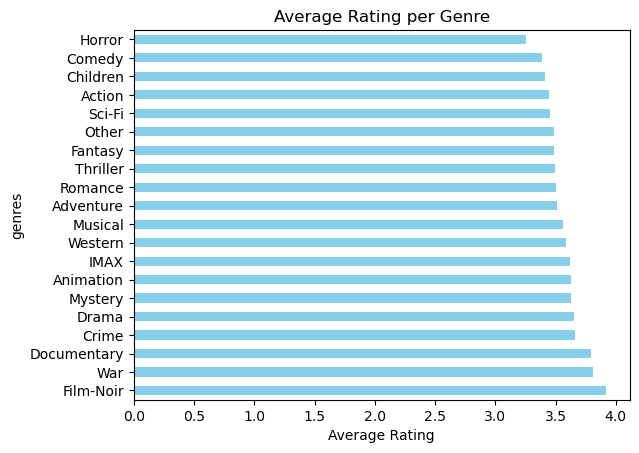

In [8]:
# Average rating per genre
movies_ratings = pd.merge(ratings, movies, on="movieId")
genre_avg = (
    movies_ratings.assign(genres=movies_ratings["genres"].str.split("|"))
    .explode("genres")
    .groupby("genres")["rating"].mean()
    .sort_values(ascending=False)
)


genre_avg.plot(kind="barh", color="skyblue")
plt.title("Average Rating per Genre")
plt.xlabel("Average Rating")
plt.show()

 ## 3. Data Preparation
 

In [9]:
# Build User-Item Matrix
user_item = ratings.pivot(index="userId", columns="movieId", values="rating").fillna(0)

In [10]:
# Aggregate tags for content-based
movie_tags = tags.groupby("movieId")["tag"].apply(lambda x: " ".join(x)).reindex(movies["movieId"]).fillna("")

In [11]:
# Merge movies and tags on movieId
movies_with_tags = movies.merge(movie_tags, on="movieId", how="left")

# Fill NaN tags with empty string
movies_with_tags["tag"] = movies_with_tags["tag"].fillna("")

# Create text field for TF-IDF
item_text = (
    movies_with_tags["title"].fillna("") + " " +
    movies_with_tags["genres"].str.replace("|", " ") + " " +
    movies_with_tags["tag"]
)


In [12]:
# Pre-compute similarities
collab_sim = cosine_similarity(user_item.T)
collab_sim_df = pd.DataFrame(collab_sim, index=user_item.columns, columns=user_item.columns)

tfidf = TfidfVectorizer(stop_words="english")
item_tfidf = tfidf.fit_transform(item_text)
content_sim = cosine_similarity(item_tfidf, item_tfidf)
content_sim_df = pd.DataFrame(content_sim, index=movies["movieId"], columns=movies["movieId"])


## 4. Content-Based Filtering (TF-IDF)

In [13]:
def recommend_content_based_movies(movie_title, top_n=5):
    """
    Recommend movies using **Content-Based Filtering**.
    This function uses TF-IDF vectorization and cosine similarity on movie
    metadata (genres + tags) to recommend movies similar to a given title.

    Parameters:
    movie_title : str
        The title of the input movie for which recommendations are generated.
    top_n : int, optional (default=5)
        Number of top similar movies to return.

    Returns:
        DataFrame containing the top-N recommended movies with: Movie title and Movie genres
    """
    movie_id = movies[movies["title"].str.contains(movie_title, case=False, regex=False)]["movieId"].values[0]
    similar_scores = content_sim_df[movie_id].sort_values(ascending=False)[1 : top_n + 1]
    return movies[movies["movieId"].isin(similar_scores.index)][["title", "genres"]]


In [14]:
print("\nContent-Based Recommendations for 'Toy Story (1995)':")
recommend_content_based_movies("Toy Story (1995)")


Content-Based Recommendations for 'Toy Story (1995)':


,title,genres
1757,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy
2355,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
3595,"Toy, The (1982)",Comedy
7039,Up (2009),Adventure|Animation|Children|Drama
7355,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX


In [15]:
print("\nContent-Based Recommendations for 'Screamers (1995)':")
recommend_content_based_movies("Screamers (1995)")


Content-Based Recommendations for 'Screamers (1995)':


,title,genres
167,Strange Days (1995),Action|Crime|Drama|Mystery|Sci-Fi|Thriller
176,Waterworld (1995),Action|Adventure|Sci-Fi
253,Outbreak (1995),Action|Drama|Sci-Fi|Thriller
3569,"One, The (2001)",Action|Sci-Fi|Thriller
6425,Next (2007),Action|Sci-Fi|Thriller


## 5. Collaborative Filtering (Item-based Similarity)

In [16]:

def recommend_userrating_based_movies(movie_title, top_n=5):
    """
    Recommend movies using **Collaborative Filtering (Item-Based Similarity)**.
    This function computes cosine similarity between movies based on user ratings.
    It then recommends movies that were rated similarly by users to the given title.

    Parameters:
    movie_title : str
        The title of the input movie for which recommendations are generated.
    top_n : int, optional (default=5)
        Number of top similar movies to return.

    Returns:
        DataFrame containing the top-N recommended movies with: Movie title and Movie genres
    """
    movie_id = movies[movies["title"].str.contains(movie_title, case=False, regex=False)]["movieId"].values[0]
    similar_scores = collab_sim_df[movie_id].sort_values(ascending=False)[1 : top_n + 1]
    return movies[movies["movieId"].isin(similar_scores.index)][["title", "genres"]]

In [17]:
print("\nUser Rating based Collaborative Recommendations for 'Toy Story (1995)':")
recommend_userrating_based_movies("Toy Story (1995)")


User Rating based Collaborative Recommendations for 'Toy Story (1995)':


,title,genres
224,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
314,Forrest Gump (1994),Comedy|Drama|Romance|War
418,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
615,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller
2355,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy


In [18]:
print("\nUser Rating based Collaborative Recommendations for 'Screamers (1995)':")
recommend_userrating_based_movies("Screamers (1995)")


User Rating based Collaborative Recommendations for 'Screamers (1995)':


,title,genres
59,Lawnmower Man 2: Beyond Cyberspace (1996),Action|Sci-Fi|Thriller
149,Lord of Illusions (1995),Horror
555,Bloodsport 2 (a.k.a. Bloodsport II: The Next K...,Action
574,"Quest, The (1996)",Action|Adventure
669,First Kid (1996),Children|Comedy


## 6. Hybrid Recommendation

In [19]:
def recommend_hybrid_movies(movie_title, top_n=5):
    """
    Recommend movies using a **Hybrid Model** (Content + Collaborative Filtering).
    This function averages similarity scores from both content-basedand collaborative filtering methods, 
    producing a balanced recommendation list that leverages both metadata similarity and user rating patterns.

    Parameters:
    movie_title : str
        The title of the input movie for which recommendations are generated.
    top_n : int, optional (default=5)
        Number of top similar movies to return.

    Returns:
    pandas.DataFrame
         DataFrame containing the top-N recommended movies with: Movie title and Movie genres   
    """
    movie_id = movies[movies["title"].str.contains(movie_title, case=False, regex=False)]["movieId"].values[0]

    cb_scores = content_sim_df[movie_id]
    cf_scores = collab_sim_df[movie_id]

    # Average the two
    hybrid_scores = (cb_scores + cf_scores) / 2.0
    similar_scores = hybrid_scores.sort_values(ascending=False)[1 : top_n + 1]

    return movies[movies["movieId"].isin(similar_scores.index)][["title", "genres"]]

In [20]:
print("\nHybrid Recommendations for 'Toy Story (1995)':")
recommend_hybrid_movies("Toy Story (1995)")


Hybrid Recommendations for 'Toy Story (1995)':


,title,genres
1757,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy
2355,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
3194,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
3568,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
7355,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX


In [21]:
print("\nHybrid Recommendations for 'Screamers (1995)':")
recommend_hybrid_movies("Screamers (1995)")


Hybrid Recommendations for 'Screamers (1995)':


,title,genres
5,Heat (1995),Action|Crime|Thriller
23,Powder (1995),Drama|Sci-Fi
59,Lawnmower Man 2: Beyond Cyberspace (1996),Action|Sci-Fi|Thriller
567,Solo (1996),Action|Sci-Fi|Thriller
595,Barb Wire (1996),Action|Sci-Fi


 ## 7. Movie-Based Evaluation

- Precision: Precision measures the proportion of retrieved items that are actually relevant.
  In this case it tells accuracy of recommendations (how many recommended items are good).
- NDCG (Normalized Discounted Cumulative Gain):NDCG measures the quality of the ranking of the recommended items, giving higher weight to relevant items appearing at the top of the list. Here it specifies ranking quality (are the good recommendations at the top?).

In [22]:
def evaluate_movie(movie_title, model_func, k=5):
    """
    Evaluate a recommendation model for a given movie.
    This function computes two ranking metrics (Precision@k and NDCG@k) to evaluate how well a recommender performs on a specific 
    input movie. The evaluation is based on the overlap between recommended movies and movies liked by users who also liked the given movie.

    Parameters:
    movie_title : str
        The title of the movie to use as input for recommendations.
    model_func : function
        The recommendation function (e.g., recommend_content_movies, 
        recommend_collab_movies, or recommend_hybrid_movies).
    k : int, optional (default=5)
        Number of top recommended movies to consider for evaluation.

    Returns:
    dict
        Dictionary with the following keys:
        - 'precision' : float
            Proportion of top-k recommended movies that are relevant.
        - 'ndcg' : float
            Normalized Discounted Cumulative Gain, measuring the ranking quality 
            of the recommendations.
    """
    # find movieId
    movie_id = movies.loc[movies["title"].str.contains(movie_title, case=False, regex=False), "movieId"].iloc[0]

    # relevant = movies liked by users who liked input movie
    users = ratings[(ratings["movieId"] == movie_id) & (ratings["rating"] >= 4)]["userId"].unique()
    relevant = set(ratings[(ratings["userId"].isin(users)) & (ratings["rating"] >= 4)]["movieId"]) - {movie_id}
    if not relevant: return None

    # recommended ids
    rec_ids = movies[movies["title"].isin(model_func(movie_title, top_n=k)["title"])]["movieId"].tolist()

    # inline metrics
    precision = len(set(rec_ids[:k]) & relevant) / k
    dcg = sum([1/np.log2(i+2) if rec in relevant else 0 for i, rec in enumerate(rec_ids[:k])])
    idcg = sum([1/np.log2(i+2) for i in range(min(len(relevant), k))])
    ndcg = dcg / idcg if idcg > 0 else 0

    return {"precision": precision, "ndcg": ndcg}


def compare_models_for_movie(movie_title, k=5):
    return pd.DataFrame({
        "Content-Based": evaluate_movie(movie_title, recommend_content_based_movies, k),
        "UserRating-Based": evaluate_movie(movie_title, recommend_userrating_based_movies, k),
        "Hybrid": evaluate_movie(movie_title, recommend_hybrid_movies, k)
    }).T


In [23]:
print(f"\nEvaluation Metrics for 'Toy Story (1995)':")
compare_models_for_movie("Toy Story (1995)")


Evaluation Metrics for 'Toy Story (1995)':


,precision,ndcg
Content-Based,0.8,0.83042
UserRating-Based,1.0,1.00000
Hybrid,1.0,1.00000


In [24]:
print(f"\nEvaluation Metrics for 'Screamers (1995)':")
compare_models_for_movie("Screamers (1995)")


Evaluation Metrics for 'Screamers (1995)':


,precision,ndcg
Content-Based,0.6,0.722727
UserRating-Based,0.8,0.868795
Hybrid,1.0,1.000000
